<font color='blue'> **Loading** </font> 

In [1]:
import numpy as np ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import pandas as pd ; import flopy ; 
from flopy.plot import styles;  from pathlib import Path; import os        ; from pathlib import Path ; from flopy.export.utils import export_array
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\bin\\mf2005.exe' ; exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\bin\\mt3d-usgs_1.1.0_64.exe'
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'                         ;  ref_data = Path('E:\\15_REPOS\\00_BETAMI\\bin\\Mnfienen\\pleasant-lake')
output_folder = Path('02_Loading_') ; output_folder.mkdir(exist_ok=True)

In [2]:
sim = flopy.mf6.MFSimulation.load     ('pleasant'  , sim_ws = str(ref_data), exe_name=exe_name)
sim.model_names ; gwf = sim.get_model ('pleasant') ; gwf.modelgrid.epsg = 3070  ; gwf.modelgrid.units  ; gwf.modelgrid  

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package oc...
    loading package chd...
    loading package sfr...
    loading package lak...
    loading package wel...
    loading package obs...
  loading solution package pleasant...


xll:552400.0; yll:387200.0; rotation:0.0; crs:EPSG:3070; units:meters; lenuni:2

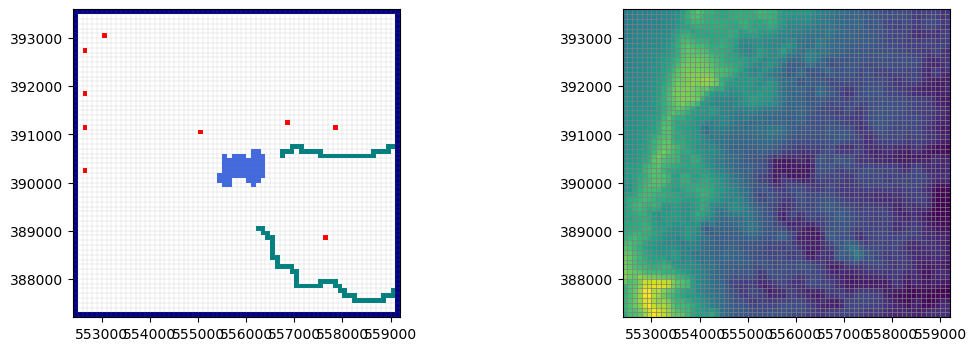

In [3]:
fig = plt.figure(figsize=(13, 4))                             
ax = fig.add_subplot(121, aspect="equal")  ; pmv = flopy.plot.PlotMapView(gwf, ax=ax)  ; lc = pmv.plot_grid(lw=0.1)  
pmv.plot_bc("WEL", plotAll=True)           ; pmv.plot_bc("LAK", plotAll=True)          ; pmv.plot_bc("SFR", plotAll=True) ; pmv.plot_bc("CHD", plotAll=True)  
ax = fig.add_subplot(122, aspect="equal")  ; pmv=flopy.plot.PlotMapView(gwf,ax=ax)     ; lc=pmv.plot_grid(lw=0.5)         ; top=pmv.plot_array(gwf.dis.top.array)
plt.show()                                 ; gwf.modelgrid.write_shapefile(str(output_folder / 'pleasant_grid.shp'))

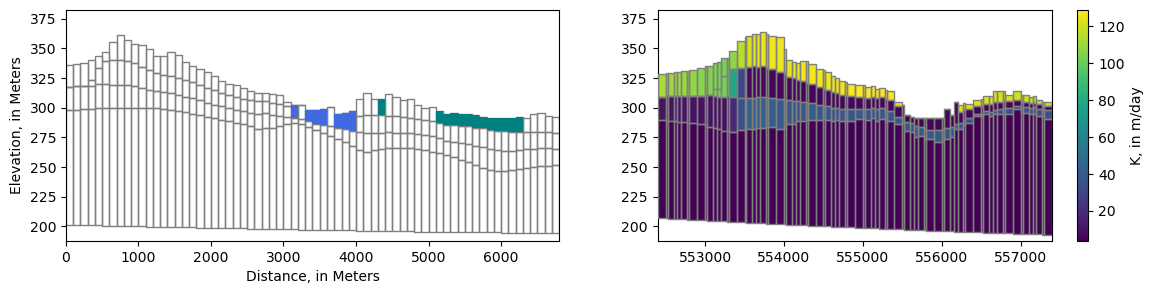

In [4]:
fig = plt.figure(figsize=(14, 3))                             
ax = fig.add_subplot(121) 
xs = flopy.plot.PlotCrossSection(model=gwf, line={"row": 30}, ax=ax)   ; lc = xs.plot_grid()  ; xs.plot_bc("LAK")  ; xs.plot_bc("SFR")
ax.set_xlabel(f'Distance, in {gwf.modelgrid.units.capitalize()}')        ; ax.set_ylabel(f'Elevation, in {gwf.modelgrid.units.capitalize()}')
ax = fig.add_subplot(122) 
xs_line = [(552400, 393000), (552400 + 5000, 393000 - 4000)]      ; xs = flopy.plot.PlotCrossSection(model=gwf, line={"line": xs_line},ax=ax,geographic_coords=True)
lc = xs.plot_grid(zorder=4) ; pc = xs.plot_array(gwf.npf.k.array)   ; fig.colorbar(pc, label='K, in m/day')
plt.show()

(13, 1, 64, 68)


,0,1
0,0,cellid_layer cellid_row cellid_column ...
1,1,cellid_layer cellid_row cellid_column q ...


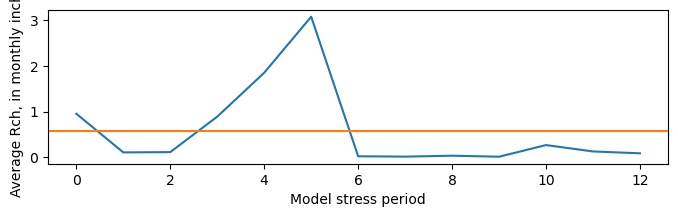

In [5]:
rec = gwf.rcha.recharge.array ;   print(rec.shape)             ; rch_inches = gwf.rcha.recharge.array[:, 0, :, :].mean(axis=(1, 2)) * 12 * 30.4 / .3048 
fig, ax = plt.subplots(figsize=(8, 2))  ; ax.plot(rch_inches)  ; ax.axhline(rch_inches.mean(), c='C1')
ax.set_ylabel(f"Average Rch, in monthly inches")               ; ax.set_xlabel("Model stress period")
aa = gwf.wel.stress_period_data.get_dataframe().items() ; ab = pd.DataFrame(aa)    ; ab.head(2)

(81, 6)
Wells =  (81, 6)


,cellid_layer,cellid_row,cellid_column,q,boundname,per
0,2,24,2,-396.867,pleasant_2-13-2,0
1,2,17,2,-409.900,pleasant_2-9-2,0
2,3,23,44,0.000,pleasant_3-12-23,0


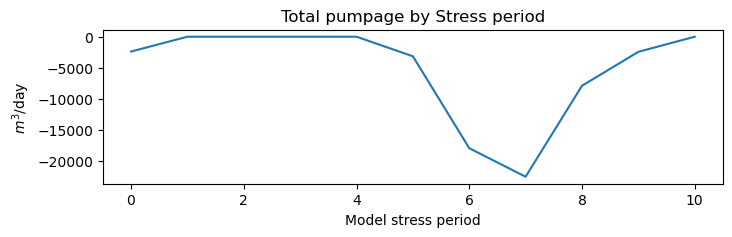

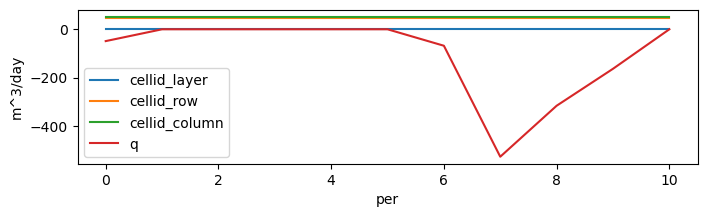

In [6]:
dfs = []
for kper, df in gwf.wel.stress_period_data.get_dataframe().items():
    df['per'] = kper
    dfs.append(df)
df = pd.concat(dfs) ; sa=pd.DataFrame(df) ;  sa.to_csv(output_folder / "A1_Wells.csv")  ; print(df.shape) ; print('Wells = ',sa.shape) 
df.groupby('per').sum()['q'].plot(figsize=(8, 2))
plt.title('Total pumpage by Stress period')  ; plt.ylabel('$m^3$/day')  ; plt.xlabel('Model stress period') 
ax = df.groupby('boundname').get_group('pleasant_3-24-27').plot(x='per', figsize=(8, 2))   ; ax.set_ylabel('m^3/day') ; df.head(3)

In [7]:
sim.run_simulation(silent=True)

(True, [])

In [8]:
from flopy.utils.postprocessing import get_water_table
hds = gwf.output.head().get_data(kstpkper=(0, 0))         ; wt = get_water_table(hds)          ; row = hds [0] 
lak_output = pd.read_csv(ref_data / 'lake1.obs.csv')      ; stage = lak_output['STAGE'][0]  
cnd = pd.DataFrame(gwf.lak.connectiondata.array)          ; k, i, j = zip( *cnd ['cellid'])                      ; wt[i, j] = stage
sfr_stage = gwf.sfr.output.stage().get_data()[0, 0, :]    ;sfr_k,sfr_i,sfr_j =zip(*gwf.sfr.packagedata.array['cellid']) ; wt [sfr_i,sfr_j]=sfr_stage
cbc = gwf.output.budget()        ; lak = cbc.get_data(text='lak', full3D=True)[0].sum(axis=0)   ; sfr = cbc.get_data(text='sfr', full3D=True)[0]
sa = pd.DataFrame(wt)            ; sa.to_csv (output_folder / "A4_Lake_wt.csv")                 ; print(wt.shape) ; print('A3_lak_output',sa.shape)
sa = pd.DataFrame(lak_output)    ; sa.to_csv (output_folder / "A3_lak_output.csv")              ; print('A2_Heads_H0',sa.shape)
sa = pd.DataFrame(row)           ; sa.to_csv (output_folder / "A2_Heads_H0.csv")                ; print('H =', hds.shape)

(64, 68)
A3_lak_output (64, 68)
A2_Heads_H0 (13, 13)
H = (4, 64, 68)


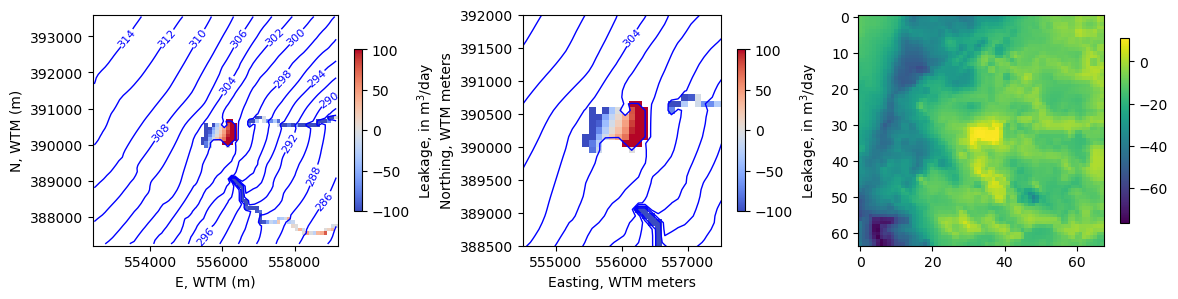

c:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\pyproj\crs\crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [9]:
fig = plt.figure(figsize=(14, 3))                             ; op = wt - gwf.dis.top.array  
ax = fig.add_subplot(131)                                                  
pmv = flopy.plot.PlotMapView(gwf, ax=ax)                                     ; levels=np.arange(280, 315, 2) 
ctr = pmv.contour_array(wt, levels=levels, linewidths=1, colors='b')       ; vmin, vmax = -100, 100
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)     ;  im = pmv.plot_array(lak, cmap='coolwarm', vmin=vmin, vmax=vmax)
im = pmv.plot_array(sfr.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='Leakage, in m$^3$/day')           ; ax.set_ylabel("N, WTM (m)") ; ax.set_xlabel("E, WTM (m)") ; ax.set_aspect(1)

ax = fig.add_subplot(132)                                                  ; new_extent = (554500, 557500, 388500, 392000)
pmv=flopy.plot.PlotMapView(gwf,ax=ax,extent = new_extent)                    ; vmin, vmax = -100, 100  ;  ax.set_aspect(1)
ctr = pmv.contour_array(wt, levels=levels, linewidths=1, colors='b')       ; labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
im = pmv.plot_array(lak, cmap='coolwarm', vmin=vmin, vmax=vmax)            ; im = pmv.plot_array(sfr.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='Leakage, in m$^3$/day')           ; ax.set_ylabel("Northing, WTM meters") ; ax.set_xlabel("Easting, WTM meters")  
ax = fig.add_subplot(133)                                                  ; plt.imshow(op);    plt.colorbar(shrink=0.8)    ; plt.show()
export_array(gwf.modelgrid, str(output_folder / 'op.tif'), op) # ; op.max(), op.min() 

Text(0, 0.5, 'Elevation, in Meters')

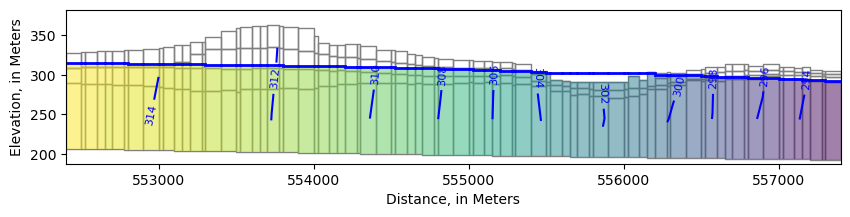

In [10]:
fig, ax = plt.subplots(figsize=(10, 2))                ; xs_line = [(552400, 393000), (552400 + 5000, 393000 - 4000)]
xs = flopy.plot.PlotCrossSection(model=gwf, line={"line" : xs_line}, ax=ax,geographic_coords=True)  #line={"row": 32},
lc  = xs.plot_grid()  ; pc = xs.plot_array(hds, head=hds, alpha=0.5, masked_values=[1e30])
ctr = xs.contour_array (hds, head=hds,  levels=levels,  colors="b",  masked_values=[1e30])
surf = xs.plot_surface(wt, masked_values=[1e30], color="blue", lw=2) ; labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=5)
ax.set_xlabel(f'Distance, in {gwf.modelgrid.units.capitalize()}') ; ax.set_ylabel(f'Elevation, in {gwf.modelgrid.units.capitalize()}')

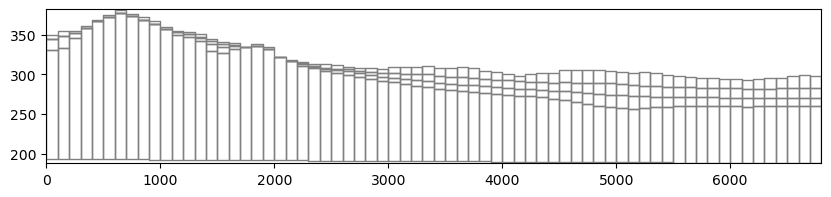

In [11]:
fig, ax = plt.subplots(figsize=(10, 2))   ; xs = flopy.plot.PlotCrossSection(model=gwf, line={"row": 62}, ax=ax)  ; lc = xs.plot_grid()

In [12]:
headobs = pd.DataFrame(gwf.obs_3.output.obs().get_data()) ;      # headobs  # m.get_package_list()    
headobs.to_csv (output_folder / "A5_OBS_3.csv")                # or   headobs = pd.read_csv(sim_ws2 / 'pleasant.head.obs')) 

### **Boundnames**

In [13]:
CHD_Bound = pd.read_csv(ref_data  /  'external/chd_001.dat'  , delim_whitespace=True)
CHD_Bound.to_csv (output_folder /  "A6_CHD_Bound.csv") 
df        = pd.read_csv(ref_data  /  'pleasant.chd.obs.output.csv')  ; df.index = df['time']  ;  # df.head()
df.to_csv        (output_folder /  "A7_Bound_2_ordered.csv")      # ModflowGwfchd(model, loading_

C:\Users\gross.DESKTOP-AIRQM2M\AppData\Local\Temp\ipykernel_17308\2231832871.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  CHD_Bound = pd.read_csv(ref_data  /  'external/chd_001.dat'  , delim_whitespace=True)


In [14]:
from flopy.utils import Mf6ListBudget 

Text(0, 0.5, 'Percent mass balance error')

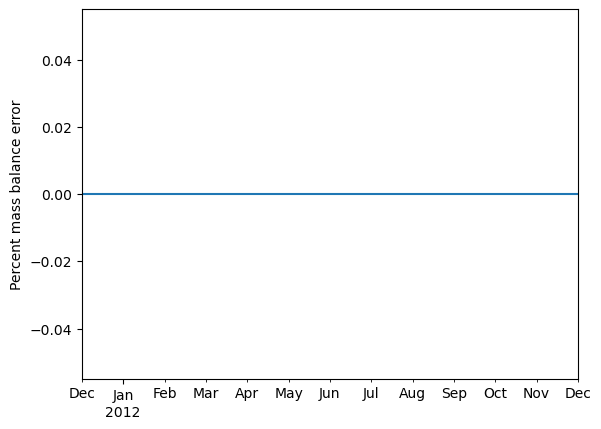

In [15]:
mfl = Mf6ListBudget(ref_data    / 'pleasant.list')             ; flux,_vol = mfl.get_dataframes(start_datetime='2011-12-30')  ; 
flux,_vol.to_csv(output_folder / "A8_Q.csv")  ;  # flux.head()
ax = flux['PERCENT_DISCREPANCY'].plot() ; ax.set_ylabel('Percent mass balance error')

Text(0, 0.5, 'Simulated Flux, in $m^3/d$')

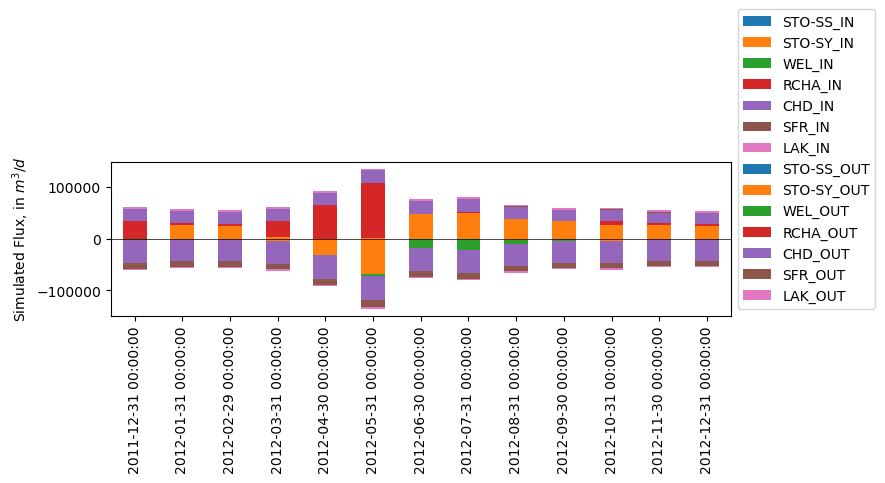

In [16]:
fig, ax  = plt.subplots(figsize=(8, 2))
in_cols  = ['STO-SS_IN', 'STO-SY_IN', 'WEL_IN', 'RCHA_IN', 'CHD_IN', 'SFR_IN', 'LAK_IN']  ; out_cols = [c.replace('_IN', '_OUT') for c in in_cols]
flux[in_cols].plot.bar(stacked=True, ax=ax)        ;    (-flux[out_cols]).plot.bar(stacked=True, ax=ax)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0)) ; ax.axhline(0, lw=0.5, c='k') ;   ax.set_ylabel('Simulated Flux, in $m^3/d$')